# Modeling timeserries using fbprophet

In [9]:
import pandas as pd
import pyodbc as db
import matplotlib as plt
import numpy as np
import fbprophet
from fbprophet.plot import add_changepoints_to_plot
import matplotlib.pyplot as plt

In [3]:
#set up db connection
con = db.connect("DRIVER={SQL Server};server=localhost;database=NewYork_Energy")
sql ='select *from NY_Load_v2'
#read to dataframe
data = pd.read_sql(sql,con)

In [4]:
#group data by day using sum
data = data.groupby([data['Date_Time'].dt.date]).sum()

In [6]:
#drop un-needed columns
data['ds']=data.index
data['y']=data['Load']
df = data.drop(columns=['Load'])

In [7]:
#make datetime axis
df['datetime']=pd.to_datetime(df.index)
df = df.set_index(df['datetime'])

#set up colums for fbprophet
df['ds']=df.index


In [8]:
#run time serries
m = fbprophet.Prophet(interval_width=.05)
m.fit(df)
future = m.make_future_dataframe(periods=4380)
forecast=m.predict(future)

C:\Users\louie\Anaconda3\lib\site-packages\fbprophet\forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\louie\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


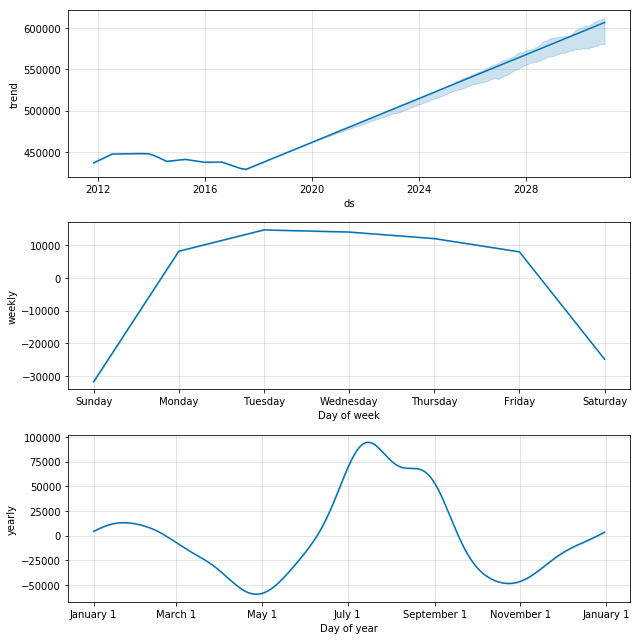

In [10]:
m.plot_components(forecast);

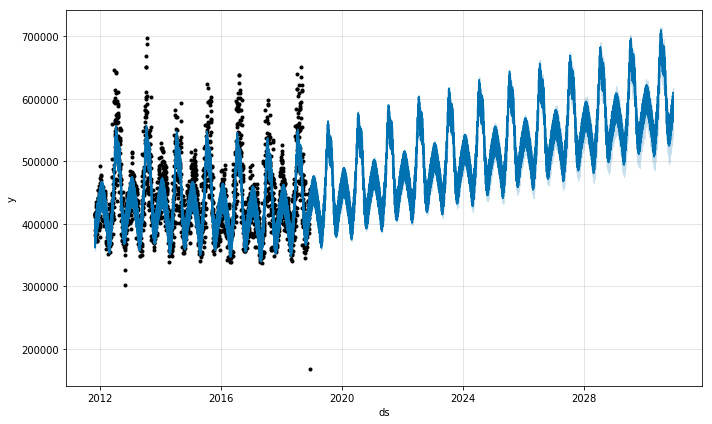

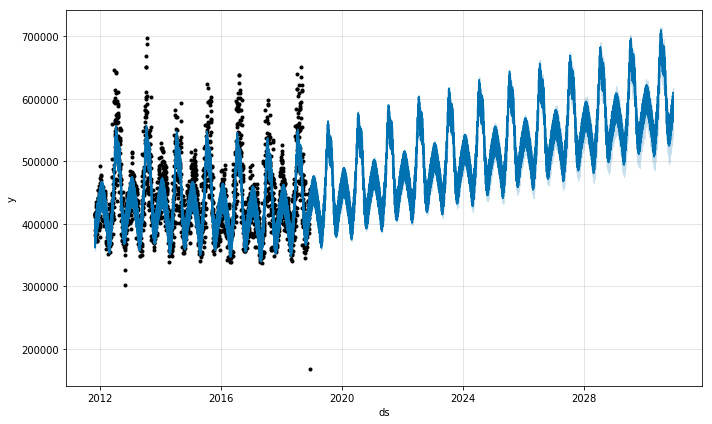

In [11]:
m.plot(forecast)

# model using auto ARIMA

In [2]:
from statsmodels.tsa.ar_model import AR
from sklearn import tree
import matplotlib.pyplot as plt
from plotly.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

In [19]:
con = db.connect("DRIVER={SQL Server};server=localhost;database=NewYork_Energy")
sql ='select *from NY_Load_v2'
data = pd.read_sql(sql,con)

,Date_Time,Time_Zone,Zone_Name,PTID,Load,Load_ID
0,2015-04-26 15:00:00,NA,GENESE,61753,948.0,1
1,2013-01-30 06:00:00,NA,CENTRL,61754,1882.0,2
2,2012-03-28 15:00:00,NA,CAPITL,61757,1310.7,3
3,2018-06-06 05:00:00,NA,GENESE,61753,874.1,4
4,2018-03-12 20:00:00,NA,MHK VL,61756,1070.2,5
5,2016-03-28 02:00:00,NA,DUNWOD,61760,516.4,6
6,2016-01-17 19:00:00,NA,HUD VL,61758,1295.3,7
7,2015-08-24 18:00:00,NA,WEST,61752,1985.1,8
8,2015-04-19 22:00:00,NA,WEST,61752,1539.1,9
9,2014-02-21 11:00:00,NA,NORTH,61755,728.4,10


In [20]:
data['Date_Time']=pd.to_datetime(data['Date_Time'])
data=data.set_index(data['Date_Time'])
data=data.resample('M').sum()

data =data.drop(columns=['PTID','Load_ID'])

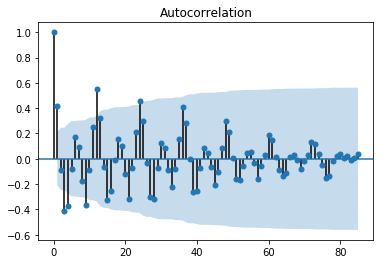

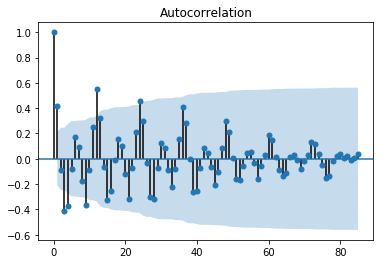

In [21]:
plot_acf(data)

In [22]:

result = seasonal_decompose(data, model='additive')
fig = result.plot()
fig.set_size_inches(30,10)
plot_mpl(fig)

'https://plot.ly/~bogolub32/24'

In [23]:
from pyramid.arima import auto_arima
stepwise_model = auto_arima(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2252.750, BIC=2264.203, Fit time=0.439 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2249.779, BIC=2254.360, Fit time=0.028 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2251.819, BIC=2260.980, Fit time=0.259 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2250.893, BIC=2260.055, Fit time=0.263 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2250.730, BIC=2257.601, Fit time=0.176 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=2250.133, BIC=2257.004, Fit time=0.185 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=2249.179, BIC=2258.341, Fit time=0.662 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=2250.226, BIC=2261.678, Fit time=0.694 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=2250.689, BIC=2262.141, Fit time=0.653 seconds
Fit ARIMA: order=(1, 1, 1) s

In [28]:
train = data[0:66]
test = data[66:86]


In [29]:
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 0),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 1, 1, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

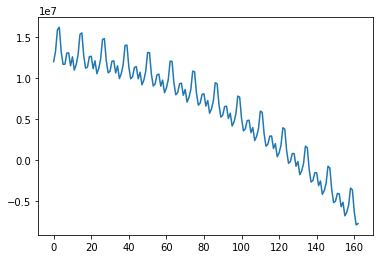

In [30]:
future_forecast = stepwise_model.predict(n_periods=163)
plt.plot(future_forecast)
plt.show()

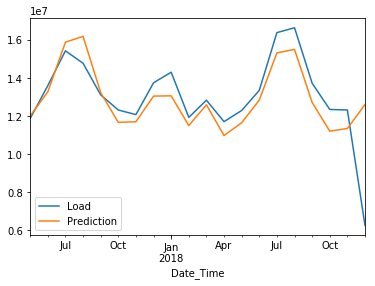

In [40]:
future_forecast_df = pd.DataFrame()
future_forecast_df['Prediction']=future_forecast[0:20]
future_forecast_df.index = test.index

pd.concat([test,future_forecast_df],axis=1).plot()